In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd /content/drive/MyDrive/UT-MedRobo/Codebases/STTR

/content/drive/MyDrive/UT-MedRobo/Codebases/STTR


In [ ]:
!pip install -r requirements.txt

In [2]:
import torch
if not torch.cuda.is_available():
    print('GPU not available.')

In [3]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

In [4]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [5]:
model = STTR(args).cuda().eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [6]:
# Load the pretrained model
model_file_name = "sceneflow_pretrained_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


In [7]:
import re

def load_pfm(file):
    with open(file, 'rb') as f:
        # Read the header
        header = f.readline().rstrip()
        if header == b'PF':
            color = True
        elif header == b'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        # Read the dimensions
        dim_match = re.match(rb'^(\d+)\s(\d+)\s$', f.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        # Read the scale
        scale = float(f.readline().rstrip())
        if scale < 0: # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>' # big-endian

        # Read the data
        data = np.fromfile(f, endian + 'f')
        shape = (height, width, 3) if color else (height, width)

        # Reshape the data into 3D array (H, W, C)
        data = np.reshape(data, shape)
        data = np.flipud(data)  # PFM files are stored in top-to-bottom order

    return data, scale

# Batch Inference

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import time
import sys
import open3d as o3d
import json
import cv2
import tifffile as tiff

def create_point_cloud(disparity_map, left_image, Q, reliability_mask):
    if disparity_map.dtype != np.float32:
        disparity_map = disparity_map.astype(np.float32)

    Q = np.array(Q, dtype=np.float32)
    if Q.shape != (4, 4):
        raise ValueError("Q matrix must be a 4x4 matrix.")

    # Apply the reliability mask to the disparity map
    filtered_disparity = np.zeros_like(disparity_map)
    filtered_disparity[reliability_mask] = disparity_map[reliability_mask]

    points_3D = cv2.reprojectImageTo3D(filtered_disparity, Q)

    # Remove points with zero disparity
    mask = filtered_disparity > 0
    output_points = points_3D[mask]
    colors = left_image[mask]
    return output_points, colors

def process_image_pair(left_path, right_path, disp_path, Q_matrix):
    left = np.array(Image.open(left_path))
    right = np.array(Image.open(right_path))
    disp, _ = load_pfm(disp_path)

    input_data = {'left': left, 'right': right, 'disp': disp}
    input_data = normalization(**input_data)

    h, w, _ = left.shape
    bs = 1
    downsample = 5
    col_offset = int(downsample / 2)
    row_offset = int(downsample / 2)
    sampled_cols = torch.arange(col_offset, w, downsample)[None, ].expand(bs, -1).cuda()
    sampled_rows = torch.arange(row_offset, h, downsample)[None, ].expand(bs, -1).cuda()

    input_data = NestedTensor(input_data['left'].cuda()[None,], input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

    output = model(input_data)

    disp_pred = output['disp_pred'].data.cpu().numpy()[0]
    occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
    disp_pred[occ_pred] = 0.0

    occ_mask = compute_left_occ_region(w, disp)
    diff = disp - disp_pred
    diff[occ_mask] = 0.0
    valid_mask = np.logical_and(disp > 0.0, ~occ_mask)
    point_cloud, colors = create_point_cloud(disp_pred, left, Q_matrix, valid_mask)
    err_px = (diff > 3).sum()
    total_px = valid_mask.sum()
    err = np.abs(diff[valid_mask]).sum()

    # Calculate absolute depth error
    depth_error = compute_depth_error(disp_pred, disp_path, Q_matrix, valid_mask, occ_mask)
    mean_depth_error = np.mean(depth_error)

    return err_px, total_px, err, mean_depth_error, disp_pred, point_cloud, colors

def load_Q_matrix(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
        Q_matrix = np.array(data["reprojection-matrix"])

    return Q_matrix

def save_pfm(filename, image, scale=1):
    with open(filename, 'wb') as file:
        color = False  # Assuming disparity maps are grayscale
        file.write(b'PF\n' if color else b'Pf\n')
        file.write(b'%d %d\n' % (image.shape[1], image.shape[0]))

        endian = image.dtype.byteorder
        if endian == '<' or endian == '=' and sys.byteorder == 'little':
            scale = -scale
        file.write(b'%f\n' % scale)
        image.tofile(file)

def compute_depth_error(disp_estimated, gt_disp_path, Q_matrix, valid_mask, occ_mask):
    """
    Compute the absolute depth error in millimeters using the Q matrix.
    """
    gt_disp, _ = load_pfm(gt_disp_path)

    # Extract focal length and baseline from Q matrix
    focal_length = Q_matrix[2][3]
    baseline = 1 / Q_matrix[3][2]

    def safe_divide(a, b):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.true_divide(a, b)
            c[~np.isfinite(c)] = 0  # Set divisions by zero and invalid results to 0
        return c

    depth_ground_truth = safe_divide(focal_length * baseline, gt_disp)

    # valid_disp_estimated = disp_estimated[valid_mask]
    # valid_depth_ground_truth = depth_ground_truth[valid_mask]

    # valid_depth_estimated = safe_divide(focal_length * baseline, valid_disp_estimated)

    # # Calculate absolute depth error
    # depth_error = np.abs(valid_depth_estimated - valid_depth_ground_truth)

    # depth_error[occ_mask] = 0.0

    occ_mask_resized = cv2.resize(occ_mask.astype(np.float32), (disp_estimated.shape[1], disp_estimated.shape[0])) > 0.5
    combined_mask = np.logical_and(valid_mask, ~occ_mask_resized)

    valid_disp_estimated = disp_estimated[combined_mask]
    valid_depth_ground_truth = depth_ground_truth[combined_mask]

    valid_depth_estimated = safe_divide(focal_length * baseline, valid_disp_estimated)

    # Calculate absolute depth error
    depth_error = np.abs(valid_depth_estimated - valid_depth_ground_truth)
    # within_threshold_mask = depth_diff < 1000
    # depth_error = depth_diff[within_threshold_mask]

    return depth_error

# Replace these paths
left_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/left_finalpass'
right_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/right_finalpass'
disp_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/disparity_left_pfm'
Q_matrix_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/reprojection_data'

total_3px_error = 0
total_epe = 0
total_inference_time = 0
total_valid_images = 0
total_depth_err = 0

# Saving results
error_file_path = '/content/drive/MyDrive/UT-MedRobo/Codebases/STTR/results/error_logs/log_dt.txt'
save_disp_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/STTR/results/result_disp'
save_point_cloud_folder = '/content/drive/MyDrive/UT-MedRobo/Codebases/STTR/result_pcds_pred'


if not os.path.exists(save_disp_folder):
    os.makedirs(save_disp_folder)
if not os.path.exists(save_point_cloud_folder):
    os.makedirs(save_point_cloud_folder)

with open(error_file_path, 'w') as file:
    for left_img in os.listdir(left_folder):
        left_path = os.path.join(left_folder, left_img)
        right_path = os.path.join(right_folder, left_img.replace('left', 'right'))
        disp_path = os.path.join(disp_folder, left_img.replace('left_finalpass', 'disparity_left_pfm').replace('.png', '.pfm'))

        Q_matrix_path = os.path.join(Q_matrix_folder, left_img.replace('.png', '.json'))
        Q_matrix = load_Q_matrix(Q_matrix_path)

        if os.path.exists(right_path) and os.path.exists(disp_path):
            print(f'Processing {left_img}...')

            start_time = time.time()

            err_px, valid_px, err, mean_depth_err, disp_pred, point_cloud, colors = process_image_pair(left_path, right_path, disp_path, Q_matrix)

            if np.isinf(mean_depth_err) or np.isnan(mean_depth_err):
              mean_depth_err = 0

            inference_time = time.time() - start_time
            total_inference_time += inference_time

            # Save the predicted disparity map
            pfm_filename = os.path.join(save_disp_folder, left_img.replace('.png', '.pfm'))
            save_pfm(pfm_filename, disp_pred)

            # Save the point cloud
            point_cloud_filename = os.path.join(save_point_cloud_folder, left_img.replace('.png', '.ply'))
            point_cloud_o3d = o3d.geometry.PointCloud()
            point_cloud_o3d.points = o3d.utility.Vector3dVector(point_cloud)
            point_cloud_o3d.colors = o3d.utility.Vector3dVector(colors / 255.0)
            o3d.io.write_point_cloud(point_cloud_filename, point_cloud_o3d)

            # Write and print the errors for each image pair
            if valid_px > 0:
                total_valid_images += 1
                image_3px_error = (err_px / valid_px) * 100
                image_epe = err / valid_px
                total_3px_error += image_3px_error
                total_epe += image_epe
                total_depth_err += mean_depth_err

                file.write(f'{left_img} - 3 px error: {image_3px_error:.3f}%, EPE: {image_epe:f}, Mean Depth Error: {mean_depth_err:.3f} mm, Inference Time: {inference_time:.3f} seconds\n')
                print(f'{left_img} - 3 px error: {image_3px_error:.3f}%, EPE: {image_epe:f}, Mean Depth Error: {mean_depth_err:.3f} mm, Inference Time: {inference_time:.3f} seconds')

            # Clear GPU memory
            torch.cuda.empty_cache()

# Calculate averages
if total_valid_images > 0:
    avg_3px_error = total_3px_error / total_valid_images
    avg_epe = total_epe / total_valid_images
    avg_inference_time = total_inference_time / total_valid_images
    avg_depth_err = total_depth_err / total_valid_images
else:
    avg_3px_error = 0
    avg_epe = 0
    avg_inference_time = 0
    avg_depth_err = 0

# Write and print averages
with open(error_file_path, 'a') as file:
    file.write(f'\nAverage 3 px error: {avg_3px_error:.3f}%\n')
    file.write(f'Average EPE: {avg_epe:f}\n')
    file.write(f'Average Depth Error: {avg_depth_err:.3f} mm\n')
    file.write(f'Average inference time per image pair: {avg_inference_time:.3f} seconds\n')

print(f'Average 3 px error: {avg_3px_error:.3f}%')
print(f'Average EPE: {avg_epe:f}')
print(f'Average Depth Error: {avg_depth_err:.3f} mm')
print(f'Average inference time per image pair: {avg_inference_time:.3f} seconds')
print(f'Error metrics written to {error_file_path}')

In [13]:
torch.cuda.empty_cache()

# Demo Prediction on Single Image Pair

In [ ]:
left = np.array(Image.open('/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/left_finalpass/frame_data000050.png'))
right = np.array(Image.open('/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/right_finalpass/frame_data000050.png'))
#disp = np.array(Image.open('sample_data/SCARED/training/disp_left/dataset_1_keyframe_1.pfm')).astype(np.float) / 256.
disp, _= load_pfm('/content/drive/MyDrive/UT-MedRobo/Codebases/Scared/dataset_1/keyframe_1/data/disparity_left_pfm/frame_data000050.pfm')
pred_disp, _ = load_pfm('/content/drive/MyDrive/UT-MedRobo/Codebases/STTR/result_disp/frame_data000050_disp.pfm')

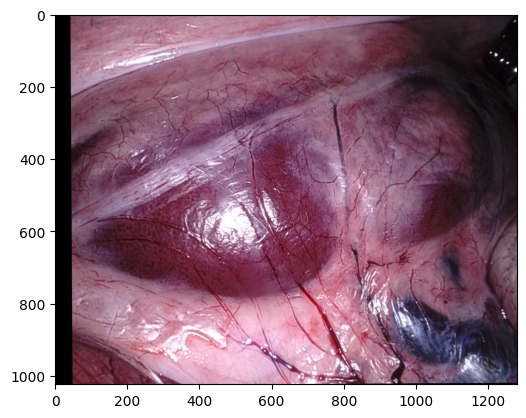

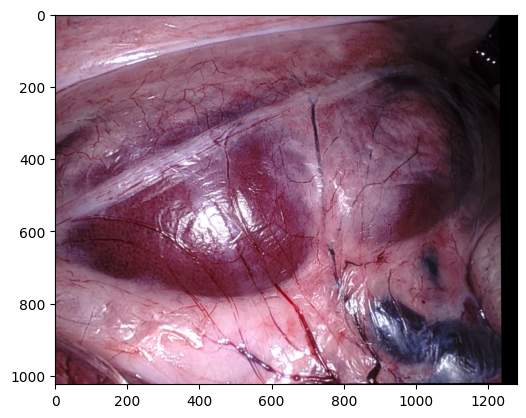

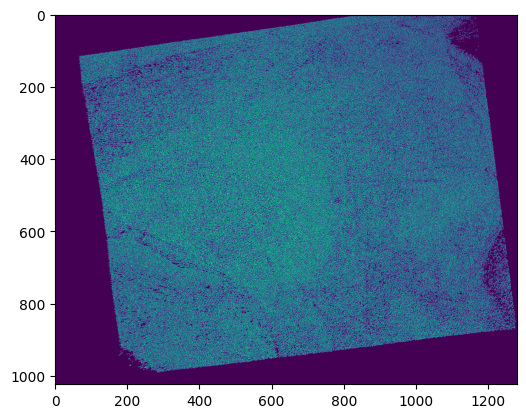

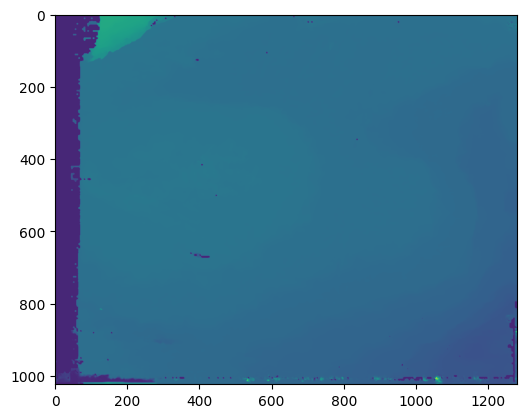

In [ ]:
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)
plt.figure(3)
plt.imshow(disp)
plt.figure(4)
plt.imshow(pred_disp)

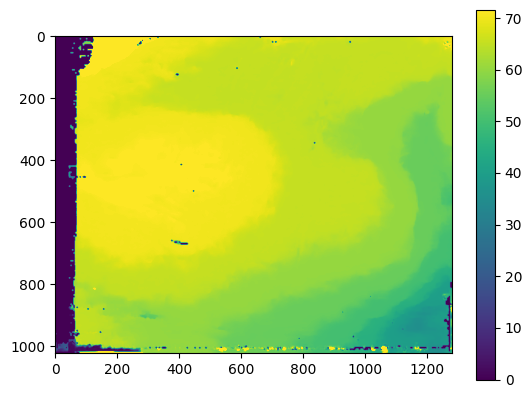

In [ ]:
plt.imshow(pred_disp, cmap='viridis', vmin=np.percentile(pred_disp, 5), vmax=np.percentile(pred_disp, 95))
plt.colorbar()  # Add a color bar to interpret the values
plt.show()

In [ ]:
# normalize
input_data = {'left': left, 'right':right, 'disp':disp}
input_data = normalization(**input_data)

In [ ]:
# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 5
col_offset = int(downsample / 2)
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

In [ ]:
# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

In [ ]:
output = model(input_data)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0

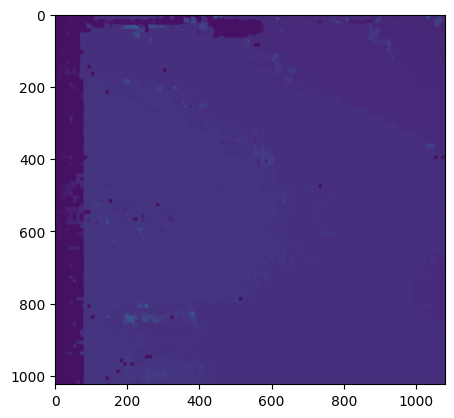

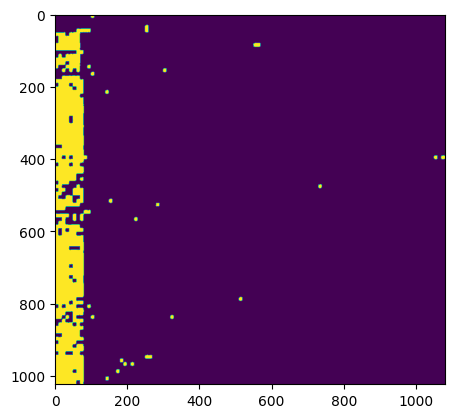

In [ ]:
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

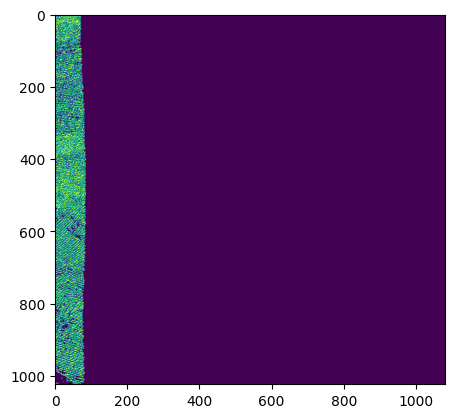

In [ ]:
# manually compute occluded region
occ_mask = compute_left_occ_region(w, disp)

# visualize the known occluded region
plt.figure(6)
plt.imshow(occ_mask)

In [ ]:
# compute difference in non-occluded region only
diff = disp - disp_pred
diff[occ_mask] = 0.0 # set occ area to be 0.0

# Note: code for computing the metrics can be found in module/loss.py
valid_mask = np.logical_and(disp > 0.0, ~occ_mask)

# find 3 px error
err_px = (diff > 3).sum()
total_px = (valid_mask).sum()
print('3 px error %.3f%%'%(err_px*100.0/total_px))

# find epe
err = np.abs(diff[valid_mask]).sum()
print('EPE %f'%(err * 1.0/ total_px))